## Observations and Insights 

In [4]:
# Observations/inferences from figures and tables in this excercise
# 1. There is a direct correlation between mouse weight and tumor volume
# 2. There is a high degree of confidence in this correlation (0.93)
# 3. Capomulin appears to be the most effective in reducing tumor volume

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_data_merged = mouse_metadata.merge(study_results, left_on="Mouse ID", right_on="Mouse ID", how="inner")

# Display the data table for preview
mouse_data_merged.head()


Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0     k403     Ramicane  Male          21          16          0   
1     k403     Ramicane  Male          21          16          5   
2     k403     Ramicane  Male          21          16         10   
3     k403     Ramicane  Male          21          16         15   
4     k403     Ramicane  Male          21          16         20   

   Tumor Volume (mm3)  Metastatic Sites  
0           45.000000                 0  
1           38.825898                 0  
2           35.014271                 1  
3           34.223992                 1  
4           32.997729                 1

In [5]:
# Checking the number of mice.
meta_count = mouse_metadata["Mouse ID"].nunique()
study_count = study_results["Mouse ID"].nunique()
merged_count = mouse_data_merged["Mouse ID"].nunique()
print(f'Mouse counts: meta: {meta_count}, study: {study_count}, merged {merged_count}')

Mouse counts: meta: 249, study: 249, merged 249


In [6]:
# From instructions: "Before beginning the analysis, check the data for any mouse ID with duplicate time points and remove 
# any data associated with that mouse ID"

# I am reading this to mean that any mouse ID with duplicated time points is suspect/invalid and all data associated with
# mouse ID must be removed from the file

# Looking at data for mouse with duplicated timepoints reinforces this interpretation because column values vary by
# timepoint, indicating that Mouse ID was entered incorrectly (duplicated another mouse), or there was something wrong with
# the way that the data was collected/entered for this ID with duplicated timepoints

In [7]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# Create a group by on ID and Timepoint - any Mouse ID/timepoint with counts greater than 1 indicates duplicates
mouse_group = mouse_data_merged.groupby(["Mouse ID", "Timepoint"])
df = mouse_group.count() 
df = df.loc[df["Drug Regimen"]>1, :]

# Create a list of mouse IDs with duplicate timepoints
mouse_group2 = df.groupby(["Mouse ID"])
mice_with_duplicated_timepoints = mouse_group2.count()
mice_with_duplicated_timepoints = mice_with_duplicated_timepoints.reset_index()
mice_with_duplicated_timepoints

Mouse ID  Drug Regimen  Sex  Age_months  Weight (g)  Tumor Volume (mm3)  \
0     g989             5    5           5           5                   5   

   Metastatic Sites  
0                 5

In [8]:
# Optional: Get all the data for the duplicate mouse ID. 

bad_mice_data = mice_with_duplicated_timepoints.merge(mouse_data_merged, left_on="Mouse ID", right_on="Mouse ID", 
                                                      how="left")
rows_to_drop = len(bad_mice_data)

bad_mice_data

Mouse ID  Drug Regimen_x  Sex_x  Age_months_x  Weight (g)_x  \
0      g989               5      5             5             5   
1      g989               5      5             5             5   
2      g989               5      5             5             5   
3      g989               5      5             5             5   
4      g989               5      5             5             5   
5      g989               5      5             5             5   
6      g989               5      5             5             5   
7      g989               5      5             5             5   
8      g989               5      5             5             5   
9      g989               5      5             5             5   
10     g989               5      5             5             5   
11     g989               5      5             5             5   
12     g989               5      5             5             5   

    Tumor Volume (mm3)_x  Metastatic Sites_x Drug Regimen_y   Sex_y  \
0                      5                   5       Propriva  Female   
1                      5                   5       Propriva  Female   
2                      5                   5       Propriva  Female   
3                      5                   5       Propriva  Female   
4                      5                   5       Propriva  Female   
5                      5                   5       Propriva  Female   
6                      5                   5       Propriva  Female   
7                      5                   5       Propriva  Female   
8                      5                   5       Propriva  Female   
9                      5                   5       Propriva  Female   
10                     5                   5       Propriva  Female   
11                     5                   5       Propriva  Female   
12                     5                   5       Propriva  Female   

    Age_months_y  Weight (g)_y  Timepoint  Tumor Volume (mm3)_y  \
0             21            26          0             45.000000   
1             21            26          0             45.000000   
2             21            26          5             48.786801   
3             21            26          5             47.570392   
4             21            26         10             51.745156   
5             21            26         10             49.880528   
6             21            26         15             51.325852   
7             21            26         15             53.442020   
8             21            26         20             55.326122   
9             21            26         20             54.657650   
10            21            26         25             56.045564   
11            21            26         30             59.082294   
12            21            26         35             62.570880   

    Metastatic Sites_y  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
5                    0  
6                    1  
7                    0  
8                    1  
9                    1  
10                   1  
11                   1  
12                   2

In [9]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# Outer join mice with duplicates to the orginal merged dataframe
# records with no match on mice with duplicates will have NaN values in the resulting fields from mice with duplicates
clean_mice_data = mice_with_duplicated_timepoints.merge(mouse_data_merged, left_on="Mouse ID", right_on="Mouse ID", 
                                                        how="outer", suffixes=("_bad",""))

# count rows before dropping mice with duplicates
rows_before_drop = len(clean_mice_data)

# identify rows to keep: rows that had no match in the outer join to mice_with_duplicated_timepoints
# drop rows that have non-zero values after replacing NaN with zero
#
# OBS!  This works in this instance, but not a good practice to continue.  At least not without additional
# data cleaning to ensure that all the values in Sex are valid (i.e. there were no zeroes in this column before
# replacing all the NaN values with zero)
#
clean_mice_data = clean_mice_data.fillna(0)
clean_mice_data = clean_mice_data.drop(clean_mice_data[clean_mice_data.Sex_bad >0].index)

# remove duplicated columns with non-values
clean_mice_data = clean_mice_data.drop([col for col in clean_mice_data if col.endswith('_bad')], 1)

# count rows in cleaned dataframe
rows_after_drop = len(clean_mice_data)

clean_mice_data.head()

Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
13     k403     Ramicane  Male          21          16          0   
14     k403     Ramicane  Male          21          16          5   
15     k403     Ramicane  Male          21          16         10   
16     k403     Ramicane  Male          21          16         15   
17     k403     Ramicane  Male          21          16         20   

    Tumor Volume (mm3)  Metastatic Sites  
13           45.000000                 0  
14           38.825898                 0  
15           35.014271                 1  
16           34.223992                 1  
17           32.997729                 1

In [10]:
# Checking the number of mice in the clean DataFrame.

# print row counts for validation
print(f'Row count before drop: {rows_before_drop}')
print(f'Count of rows to drop: {rows_to_drop}')
print(f'Row count after drop (clean dataframe): {rows_after_drop}')


Row count before drop: 1893
Count of rows to drop: 13
Row count after drop (clean dataframe): 1880


## Summary Statistics

In [11]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

# create a groupby on "Drug Regimen" and then calculate statistics, appending to new df as each list is calced
regimen_group = clean_mice_data.groupby(["Drug Regimen"])
regimen_summary_df = regimen_group["Tumor Volume (mm3)"].mean().reset_index()\
        .rename(columns={"Tumor Volume (mm3)":"Mean"})
regimen_summary_df = pd.merge(regimen_summary_df, regimen_group["Tumor Volume (mm3)"].median(), on="Drug Regimen")\
        .rename(columns={"Tumor Volume (mm3)":"Median"})
regimen_summary_df = pd.merge(regimen_summary_df, regimen_group["Tumor Volume (mm3)"].var(), on="Drug Regimen")\
        .rename(columns={"Tumor Volume (mm3)":"Variance"})
regimen_summary_df = pd.merge(regimen_summary_df, regimen_group["Tumor Volume (mm3)"].std(), on="Drug Regimen")\
        .rename(columns={"Tumor Volume (mm3)":"Std Dev"})
regimen_summary_df = pd.merge(regimen_summary_df, regimen_group["Tumor Volume (mm3)"].sem(), on="Drug Regimen")\
        .rename(columns={"Tumor Volume (mm3)":"SEM"})

regimen_summary_df


Drug Regimen       Mean     Median   Variance   Std Dev       SEM
0    Capomulin  40.675741  41.557809  24.947764  4.994774  0.329346
1     Ceftamin  52.591172  51.776157  39.290177  6.268188  0.469821
2    Infubinol  52.884795  51.820584  43.128684  6.567243  0.492236
3     Ketapril  55.235638  53.698743  68.553577  8.279709  0.603860
4     Naftisol  54.331565  52.509285  66.173479  8.134708  0.596466
5      Placebo  54.033581  52.288934  61.168083  7.821003  0.581331
6     Propriva  52.320930  50.446266  43.852013  6.622085  0.544332
7     Ramicane  40.216745  40.673236  23.486704  4.846308  0.320955
8     Stelasyn  54.233149  52.431737  59.450562  7.710419  0.573111
9    Zoniferol  53.236507  51.818479  48.533355  6.966589  0.516398

In [12]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line

regimen_summary2_df = regimen_group.agg({"Tumor Volume (mm3)" : ["mean", "median", "var", "std", "sem"]})

regimen_summary2_df

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

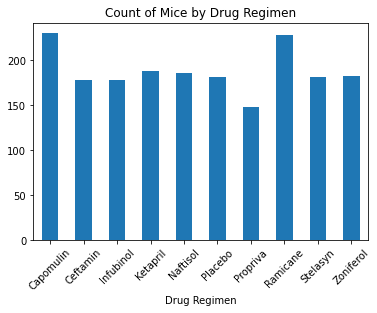

In [13]:
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pandas.

# get count of mice on each regimen from the regimen groupby created above
count_df = regimen_group["Tumor Volume (mm3)"].count().reset_index()\
        .rename(columns={"Tumor Volume (mm3)":"Count of Mice"})

# create bar plot using pandas
count_df.plot.bar(x="Drug Regimen", y="Count of Mice", rot=45,legend=False,title="Count of Mice by Drug Regimen")
plt.show()


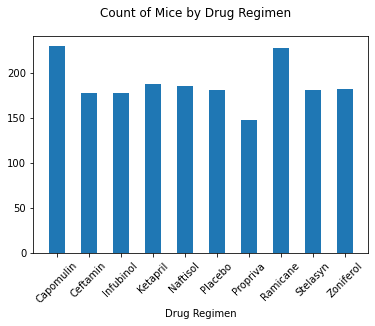

In [14]:
# Generate a bar plot showing the total number of unique mice tested on each drug regimen using pyplot.

# get data for x and y axes
y_axis = count_df["Count of Mice"].tolist()
x_labels = count_df["Drug Regimen"].tolist()
x_axis = np.arange(len(y_axis))

# create bar chart using matplotlib 
fig = plt.figure()
plt.bar(x_axis, y_axis, color="#1f77b4", alpha=1, align="center",width=0.5)
fig.suptitle("Count of Mice by Drug Regimen", fontsize=12)
plt.xticks(x_axis, x_labels, rotation="45")
plt.xlabel('Drug Regimen')
plt.show()

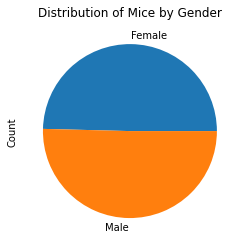

In [15]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
# To do: figure out how to get rid of "Count" on the left side of the pie chart

# copy clean mice data to another df in order to rename "Mouse ID" to "Count"
# To do: figure out how to get rid of label on the left side of the pie chart
# in the meantime, "Count" makes more sense as a label than "Mouse ID"
df = clean_mice_data.rename(columns={"Mouse ID":"Count"})

# count number of unique "Mouse ID" ("Count") by gender ("Sex")
gender_df = df.groupby("Sex")["Count"].nunique()

gender_df.plot.pie(title="Distribution of Mice by Gender")
plt.show()

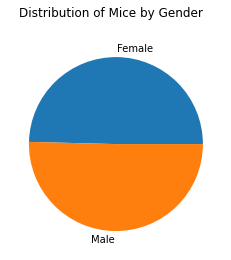

In [16]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

# reset index on gender data frame in order to pull gender labels and counts into separate lists
gender_df2 = gender_df.reset_index()
gender_list = gender_df2["Sex"].tolist()
gender_count = gender_df2["Count"].tolist()

# plot pie chart with matplotlib
fig = plt.figure()
plt.pie(gender_count, labels=gender_list)
fig.suptitle("Distribution of Mice by Gender", fontsize=12)
plt.show()

## Quartiles, Outliers and Boxplots

In [17]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the record with last (greatest) timepoint for each mouse
# Record with the last timepoint contains the final tumor volume
last_timepoint_df = clean_mice_data.sort_values("Timepoint", ascending=False).drop_duplicates(["Mouse ID"])


In [18]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
tumor_vol = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
    
# Locate the rows which contain mice on each drug and get the tumor 
# build df by brute force
# To do: figure out why my for loop + data selection criteria using list is not working
treatment_subset_df = last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Capomulin"), :]
treatment_subset_df = treatment_subset_df.append(last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Ramicane"), :])
treatment_subset_df = treatment_subset_df.append(last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Infubinol"), :])
treatment_subset_df = treatment_subset_df.append(last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Ceftamin"), :])

# populate tumor_vol (create above) with tumor volume data from treatment subset
tumor_vol = treatment_subset_df["Tumor Volume (mm3)"]    
    
# Determine outliers using upper and lower bounds
quartiles = tumor_vol.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of final tumor volumes is: {lowerq}")
print(f"The upper quartile of final tumor volumes is: {upperq}")
print(f"The interquartile range of final tumor volumes is: {iqr}")
print(f"The the median of final tumor volumes is: {quartiles[0.5]} ")
print("")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

treatment_subset_df

# I have obviously done something wrong here:  There are no outliers (below 3.07 and above 94.0)
# not sure if this means I have pulled the wrong data (don't think so, I'm pretty sure I just need one record for 
# the last timepoint for each mouse all of the 4 regimens)

The lower quartile of final tumor volumes is: 37.187743802499995
The upper quartile of final tumor volumes is: 59.930261755000004
The interquartile range of final tumor volumes is: 22.74251795250001
The the median of final tumor volumes is: 45.0 

Values below 3.0739668737499812 could be outliers.
Values above 94.04403868375002 could be outliers.


Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
373      g316    Capomulin  Female          22          22         45   
137      y793    Capomulin    Male          17          17         45   
363      v923    Capomulin  Female          19          21         45   
147      r554    Capomulin  Female           8          17         45   
350      j119    Capomulin  Female           7          23         45   
...       ...          ...     ...         ...         ...        ...   
940      h531     Ceftamin    Male           5          27          5   
1743     x226     Ceftamin    Male          23          28          0   
607      b447     Ceftamin    Male           2          30          0   
1583     u153     Ceftamin  Female          11          25          0   
1551     t573     Ceftamin  Female          15          27          0   

      Tumor Volume (mm3)  Metastatic Sites  
373            40.159220                 2  
137            31.896238                 2  
363            40.658124                 2  
147            32.377357                 3  
350            38.125164                 1  
...                  ...               ...  
940            47.784682                 0  
1743           45.000000                 0  
607            45.000000                 0  
1583           45.000000                 0  
1551           45.000000                 0  

[100 rows x 8 columns]

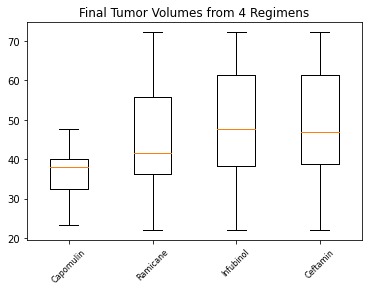

In [19]:
# create data to be plotted, 4 lists: last tumor volumes for each of the 4 regimens
# parse out regimens 
Ca_df = last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Capomulin"), :]
Ra_df = treatment_subset_df.append(last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Ramicane"), :])
In_df = treatment_subset_df.append(last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Infubinol"), :])
Ce_df = treatment_subset_df.append(last_timepoint_df.loc[(last_timepoint_df["Drug Regimen"] == "Ceftamin"), :])

# parse out tumor volumes
Ca = Ca_df["Tumor Volume (mm3)"]
Ra = Ra_df["Tumor Volume (mm3)"]    
In = In_df["Tumor Volume (mm3)"]    
Ce = Ce_df["Tumor Volume (mm3)"]   

# format all on box plot
# adding code to format outliers in different color and style even though I'm not getting any outliers
red_diamond = dict(markerfacecolor='r', marker='D', markersize=12)

data = [Ca, Ra, In, Ce]
fig, ax = plt.subplots()
ax.set_title('Final Tumor Volumes from 4 Regimens')
ax.set_xticklabels(treatments, rotation=45, fontsize=8)
ax.boxplot(data,flierprops=red_diamond)
plt.show()

# See note about no outliers, above

## Line and Scatter Plots

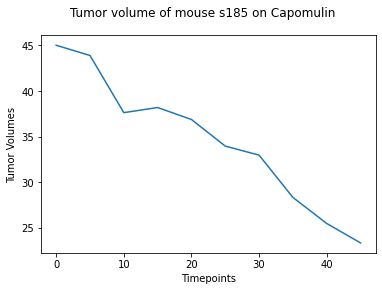

In [20]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

# get records for Capomulin regimen
Capomulin_records_df = clean_mice_data.loc[(clean_mice_data["Drug Regimen"] == "Capomulin"), :]

# get records for one mouse on Capomulin
One_mouse_records_df = Capomulin_records_df.loc[(clean_mice_data["Mouse ID"] == Capomulin_records_df.iloc[0]["Mouse ID"]), :]
mouse_shown = One_mouse_records_df.iloc[0][0]

# get list tumor volumes for the mouse
tumor_volumes_list = One_mouse_records_df["Tumor Volume (mm3)"].tolist()

# get list of time points
timepoints_list = One_mouse_records_df["Timepoint"].tolist()

# format title for plot
title = 'Tumor volume of mouse ' + mouse_shown + ' on Capomulin'

# create line plot
fig = plt.figure()
plt.plot(timepoints_list, tumor_volumes_list)
fig.suptitle(title, fontsize=12)
plt.xlabel('Timepoints')
plt.ylabel('Tumor Volumes')
plt.show()


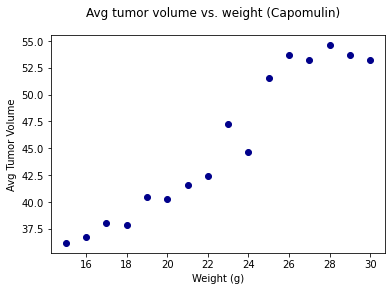

In [21]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen
weight_group = clean_mice_data.groupby(["Weight (g)"])
weight_summary_df = weight_group.agg({"Tumor Volume (mm3)" : "mean"})

weight_summary_df = weight_summary_df.reset_index()
weight_list2 = weight_summary_df["Weight (g)"]
avg_tumor_vol_list = weight_summary_df["Tumor Volume (mm3)"]

fig = plt.figure()
plt.scatter(weight_list2, avg_tumor_vol_list, marker="o", facecolors="darkblue")
fig.suptitle("Avg tumor volume vs. weight (Capomulin)", fontsize=12)
plt.xlabel('Weight (g)')
plt.ylabel('Avg Tumor Volume')
plt.show()



## Correlation and Regression


Correlation coefficient: 0.93
Linear regression model: y = 1.41x + 13.6



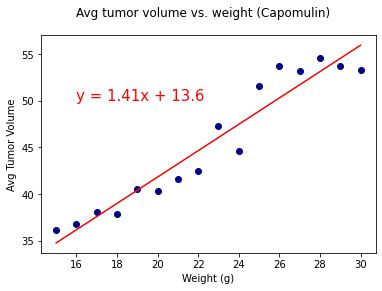

In [22]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

# run linregress to get components for correlaton coefficient and regression model
(slope, intercept, rvalue, pvalue, stderr) = linregress(weight_list2, avg_tumor_vol_list)
regress_values = weight_list2 * slope + intercept

# calc correlation coefficient and format regression model equation
correlation_coefficient = round(rvalue**2, 2)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

print ()
print (f'Correlation coefficient: {correlation_coefficient}')
print (f'Linear regression model: {line_eq}')
print ()



fig = plt.figure()
plt.scatter(weight_list2, avg_tumor_vol_list, marker="o", facecolors="darkblue")
plt.plot(weight_list2,regress_values,"r-")
plt.annotate(line_eq,(16,50),fontsize=15,color="red")
fig.suptitle("Avg tumor volume vs. weight (Capomulin)", fontsize=12)
plt.xlabel('Weight (g)')
plt.ylabel('Avg Tumor Volume')
plt.show()
